# Zaawansowane przetwarzanie obrazów

## Klasyfikacja - rozszerzenie

In [1]:
# Install the requirements
!pip install lightning albumentations timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 14.5 MB/s eta 0:00:00


## Biblioteka `albumentations`

[albumentations](https://albumentations.ai/) jest zaawansowaną biblioteką umożliwiającą augmentację danych w różnych zadaniach (klasyfikacja, regresja, segmentacja detekcja). Wykorzystamy ją do wzbogacania danych ze zbioru zdjęć psów i kotów.

### Zadanie

Zapoznaj się z tutorialem `albumentations` i zdefiniuj klasę dziedziczącą po `torch.utils.data.Dataset`, która będzie odpowiadała za wczytywanie, augmentowanie i zwracanie obrazów wraz z odpowiadającymi im etykietami: https://albumentations.ai/docs/examples/pytorch_classification/#Define-a-PyTorch-dataset-class.

Na podstawie dokumentacji [LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) zaimplementuj własny moduł porządkujący kod obsługi danych. Podobnie jak w tutorialu, to w nim umieść augmentacje treningowe oraz transformacje dla zbioru walidacyjnego i testowego używając obiektów biblioteki `albumentations` (zamiast `torchvision`).

Do podziału ścieżek na zbiór treningowy, walidacyjny i testowy można wykorzystać funkcję biblioteki `scikit-learn`: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Wytrenuj model z poprzednich zajęć zastępując osobno przekazywane obiekty `DataLoader` zaimplementowanym `LightningDataModule`.

In [2]:
import torch
import numpy as np
import albumentations as A

from PIL import Image
from torch.utils.data import Dataset
from pathlib import Path


class CatsVsDogsDataset(Dataset):
    def __init__(self, images_paths: list[Path], transforms: A.Compose):
        self._images_paths = images_paths
        self._transforms = transforms
        self._classes = {
            'Cat': 0,
            'Dog': 1
        }

    def __len__(self):
        return len(self._images_paths)

    def __getitem__(self, index: int) -> tuple[torch.Tensor, int]:
        image_path = self._images_paths[index]

        image = np.asarray(Image.open(image_path).convert('RGB'))
        image = self._transforms(image=image)['image']

        class_name = image_path.parent.name
        class_id = self._classes[class_name]

        return image, class_id


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
import os
import shutil
from urllib.request import urlopen
from pathlib import Path

import lightning.pytorch as pl
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import albumentations as A
import albumentations.pytorch.transforms


class CatsVsDogsDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()

        self.augmentations = A.Compose([
            A.Resize(224, 224),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.75),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            A.pytorch.transforms.ToTensorV2(),
        ])
        self.transforms = A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            A.pytorch.transforms.ToTensorV2(),
        ])

        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None


    def prepare_data(self):
        # Download and unpack the data if necessary
        if not os.path.exists('PetImages'):
            response = urlopen('https://chmura.put.poznan.pl/s/VtRYnXtQPpEtlqz/download')
            with open('images.zip', 'wb') as output_file:
                shutil.copyfileobj(response, output_file)

            shutil.unpack_archive('images.zip')

    def fiter_paths(self, images_paths: list[Path]) -> list[Path]:
        valid_paths = []
        for image_path in images_paths:
            try:
                Image.open(image_path)
                valid_paths.append(image_path)
            except:
                print(f'Invalid image: {image_path}')

        return valid_paths

    def setup(self, stage):
        # Split the data and assign datasets for use in dataloaders
        images_paths = sorted(list(Path('PetImages').rglob('*.jpg')))
        images_paths = self.fiter_paths(images_paths)

        train_paths, val_paths = train_test_split(images_paths, test_size=0.2,
                                                  random_state=42)
        val_paths, test_paths = train_test_split(val_paths, test_size=0.5,
                                                 random_state=42)


        self.train_dataset = CatsVsDogsDataset(train_paths, self.augmentations)
        self.val_dataset = CatsVsDogsDataset(val_paths, self.transforms)
        self.test_dataset = CatsVsDogsDataset(test_paths, self.transforms)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=32)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=32)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=32)

In [4]:
import lightning.pytorch as pl
import torchmetrics
import torchvision
import timm

from torch import nn


class LitModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT),
            nn.Linear(in_features=1000, out_features=512),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=2)
        )
        self.loss_function = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=2)

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)

        self.accuracy.update(outputs, labels)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.accuracy, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)

        self.accuracy.update(outputs, labels)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)

        self.accuracy.update(outputs, labels)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.accuracy, prog_bar=True)

    def configure_optimizers(self):
        # Tym razem użyjmy optimizera Adam - uczenie powinno być szybsze
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [12]:
!pip install neptune

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.3 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67675 sha256=112cc57b54cc422d3751797293d2c2062bd3065928cff3754641638e935bef16
  Stored in directory: /root/.cache/pip/wheels/42/35/4a/44ec4c358db21a5d63ed4e40f0f0012a438106f220bce4ccba
Successfully built bravado-core


In [13]:
import lightning.pytorch as pl
import torchmetrics
import torchvision
import timm
import neptune

from torch import nn

# Open the api key for neptune
with open('neptune-api-key.txt') as f:
    api_key = f.read()

class LitModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.network = timm.create_model('mobilenetv3_small_050.lamb_in1k', pretrained=True, num_classes=2)
        self.loss_function = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=2)

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)

        self.accuracy.update(outputs, labels)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.accuracy, prog_bar=True)

        run['train/loss'].append(loss)
        run['train/acc'].append(self.accuracy)

        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)

        self.accuracy.update(outputs, labels)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy, prog_bar=True)

        run['val/loss'].append(loss)
        run['val/acc'].append(self.accuracy)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)

        self.accuracy.update(outputs, labels)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.accuracy, prog_bar=True)

        run['test/loss'].append(loss)
        run['test/acc'].append(self.accuracy)

    def configure_optimizers(self):
        # Tym razem użyjmy optimizera Adam - uczenie powinno być szybsze
        run['hyperparameters'] = {
            'learning_rate': 1e-3,
            'optimizer': 'Adam'
        }
        return torch.optim.Adam(self.parameters(), lr=1e-3)

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/mmcza/zpo5/e/ZPO-1


In [15]:
lightning_model = LitModel()
data_module = CatsVsDogsDataModule()

run = neptune.init_run(
    project="mmcza/zpo5",
    api_token=api_key,
)

trainer = pl.Trainer(accelerator='gpu', max_epochs=5)
trainer.fit(lightning_model, datamodule=data_module)

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/mmcza/zpo5/e/ZPO-2


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Invalid image: PetImages/Cat/666.jpg
Invalid image: PetImages/Dog/11702.jpg


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | network       | MobileNetV3        | 570 K  | train
1 | loss_function | CrossEntropyLoss   | 0      | train
2 | accuracy      | MulticlassAccuracy | 0      | train
-------------------------------------------------------------
570 K     Trainable params
0         Non-trainable params
570 K     Total params
2.281     Total estimated model params size (MB)
237       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | network       | MobileNe

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 33 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 33 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/mmcza/zpo5/e/ZPO-2/metadata
Invalid image: PetImages/Cat/666.jpg
Invalid image: PetImages/Dog/11702.jpg


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

InactiveRunException: 
[95m
----InactiveRunException----------------------------------------
[0m
It seems you are trying to log metadata to (or fetch it from) a run that was stopped (ZPO-2).

Here's what you can do:
    - Resume the run to continue logging to it:
    https://docs.neptune.ai/logging/to_existing_object/
    - Don't invoke `stop()` on a run that you want to access. If you want to stop monitoring only,
    you can resume a run in read-only mode:
    https://docs.neptune.ai/api/connection_modes/#read-only-mode

You may also want to check the following docs pages:
    - https://docs.neptune.ai/logging/to_existing_object/
    - https://docs.neptune.ai/usage/querying_metadata/

[92mNeed help?[0m-> https://docs.neptune.ai/getting_help


tensor([[0.0362, 0.9638]], grad_fn=<SoftmaxBackward0>)


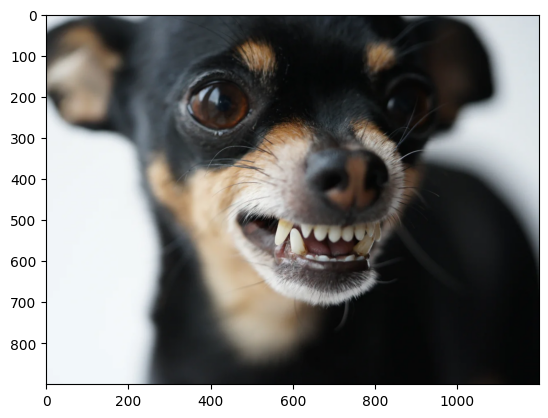

In [16]:
import matplotlib.pyplot as plt

image = Image.open('dog.png').convert('RGB')

plt.imshow(image)

image = data_module.transforms(image=np.asarray(image))['image']

lightning_model.eval()

outputs = lightning_model(image[None, ...])
print(torch.softmax(outputs, dim=1))

## Biblioteka `timm`

Biblioteka [pytorch-image-models](https://github.com/huggingface/pytorch-image-models) (w skrócie `timm`) zawiera implementacje wielu architektur sieci neuronowych. Rozwija się zdecydowanie szybciej od `torchvision` i jest łatwiejsza w obsłudze.

Zapoznaj się z początkiem [dokumentacji](https://huggingface.co/docs/hub/timm), który pokazuje jak utworzyć model z wykorzystaniem tej biblioteki.

### Zadanie

Zmodyfikuj kod swojego `LightningModule` tak, aby używał modeli z biblioteki `timm`. Przykładowe nazwy architektur:
* `resnet10t`
* `resnet18`
* `mobilenetv3_small_050.lamb_in1k`
* `mobilenetv3_small_075.lamb_in1k`

Zwróć uwagę, że przy tworzeniu modelu można określić liczbę klas wyjściowych parametrem `num_classes`, co likwiduje konieczność dodawania jakichkolwiek dodatkowych warstw w pełni połączonych za gotową architekturą.

## Narzędzia do śledzenia przebiegu eksperymentów

Istnieje wiele narzędzi umożliwiających śledzenie eksperymentów uczenia maszynowego. Oferują one podgląd przebiegu funkcji kosztu oraz metryk.

Oprócz darmowego [MLFlow](https://mlflow.org/) warto wymienić kilka komercyjnych rozwiązań:
* [Neptune](https://neptune.ai/)
* [Weights and Biases](https://wandb.ai/site)
* [Comet](https://www.comet.com)

`MLFlow` wymaga utworzenia serwera śledzenia eksperymentu, co jest utrudnione w przypadku środowiska Google Colab.

### Zadanie

Załóż darmowe konto https://neptune.ai, utwórz projekt oraz skonfiguruj odpowiednio `Trainer` w bibliotece `Lightning` aby rozpocząć śledzenie eksperymentów: https://lightning.ai/docs/pytorch/stable/extensions/generated/lightning.pytorch.loggers.NeptuneLogger.html#lightning.pytorch.loggers.NeptuneLogger.

Obiekt `NeptuneLogger` wymaga podania jedynie dwóch argumentów: nazwy projektu oraz klucza API, który może być również przekazany poprzez zmienną środowiskową `NEPTUNE_API_KEY`.

## Implementacja ResNet-18

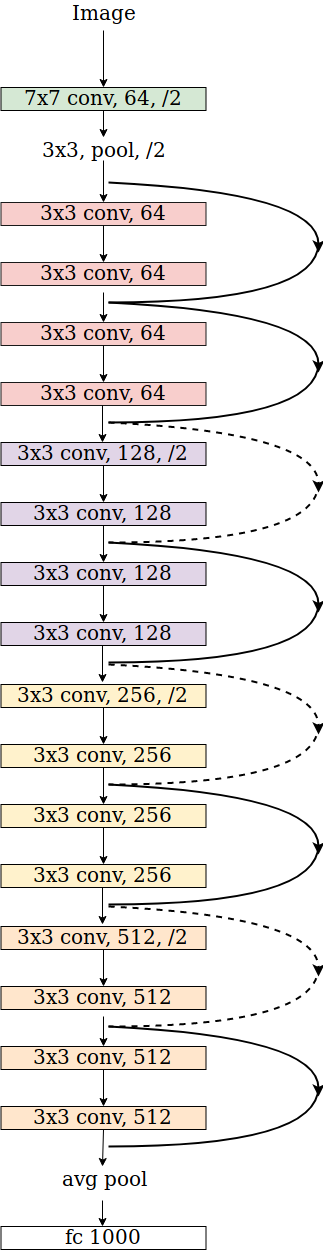